In [1]:
%matplotlib inline

import os
import sys
from itertools import product
import numpy as np
np.set_printoptions(precision=4,suppress=True, linewidth=140)
import scipy

import matplotlib.pyplot as plt

from h5 import HDFArchive
from triqs.gf import *
from triqs.gf.descriptors import Fourier, Omega
from triqs.plot.mpl_interface import plt,oplot
from triqs.lattice.utils import TB_from_wannier90, k_space_path

import solid_dmft.postprocessing.plot_correlated_bands as pcb
import solid_dmft.postprocessing.maxent_sigma as sigma_maxent

Starting serial run at: 2023-04-13 14:24:35.028682


In [2]:
w90_dict = {'w90_path': '../../',
            'w90_seed': 'nio',
            'add_spin': False, 'add_lambda': None,
            'n_orb': 8,
            'mu': 15.514,
            'orbital_order_w90': [0]}


plot_dict = {'colorscheme_bands': 'coolwarm', 'colorscheme_kslice': 'coolwarm', 'proj_on_orb': None, 'vmin': 0.0}

tb_bands = {'bands_path': [('L', 'G'), ('G', 'X'), ('X', 'W'),('W','L'),('L','K'),('K','G')], 'n_k': 50, 'G': [ 0.0,  0.0,  0.0], 'L': [ 0.00, 0.00 ,0.50], 'X': [0.50, 0.00, 0.50 ],'W':[0.25 ,-0.25, 0.5],'K':[0.00, -0.375, 0.375]}

tb_bands_data, alatt_k_w_path, freq_dict = pcb.get_dmft_bands(orbital_order_to = [0],mu_tb=15.514,add_mu_tb=True,eta=0.5, **w90_dict, **tb_bands)

band_data = np.loadtxt('../../nio_band.dat') 

H(R=0):
     14.0261  0.0000  0.0003 -0.0017  0.0000 -0.0233 -0.0322 -0.0178
      0.0000 14.1624  0.0000  0.0000 -0.0875  0.0117  0.0490  0.0316
      0.0003  0.0000 14.1450 -0.0905  0.0000  0.0068  0.0277  0.0187
     -0.0017  0.0000 -0.0905 14.1027  0.0000  0.0195  0.0330  0.0317
      0.0000 -0.0875  0.0000  0.0000 14.1040  0.0312  0.0684  0.0336
     -0.0233  0.0117  0.0068  0.0195  0.0312 11.2558  0.0000  0.0028
     -0.0322  0.0490  0.0277  0.0330  0.0684  0.0000 11.2697  0.0000
     -0.0178  0.0316  0.0187  0.0317  0.0336  0.0028  0.0000 11.2682


In [3]:
with HDFArchive('./nio.h5','r') as h5:
    # the next two lines load all directly measured observables and the convergence metrics per iteration
    obs = h5['DMFT_results/observables']
    conv_obs = h5['DMFT_results/convergence_obs']
    # The next lines load the last iteration impurity Green function and self-energies
    Sigma_imp_iw = h5['DMFT_results/last_iter/Sigma_freq_0']
    G_imp_iw = h5['DMFT_results/last_iter/Gimp_freq_0']
#    G_imp_tau_mc = h5['DMFT_results/last_iter/G_time_orig_0']
    G_imp_tau = h5['DMFT_results/last_iter/Gimp_time_0']
#    G_imp_leg = h5['DMFT_results/last_iter/Gimp_l_0']
    # last, the chemical potential and double counting potential
    mu = h5['DMFT_results']['last_iter']['chemical_potential_post']
    dc = h5['DMFT_results']['last_iter']['DC_pot']

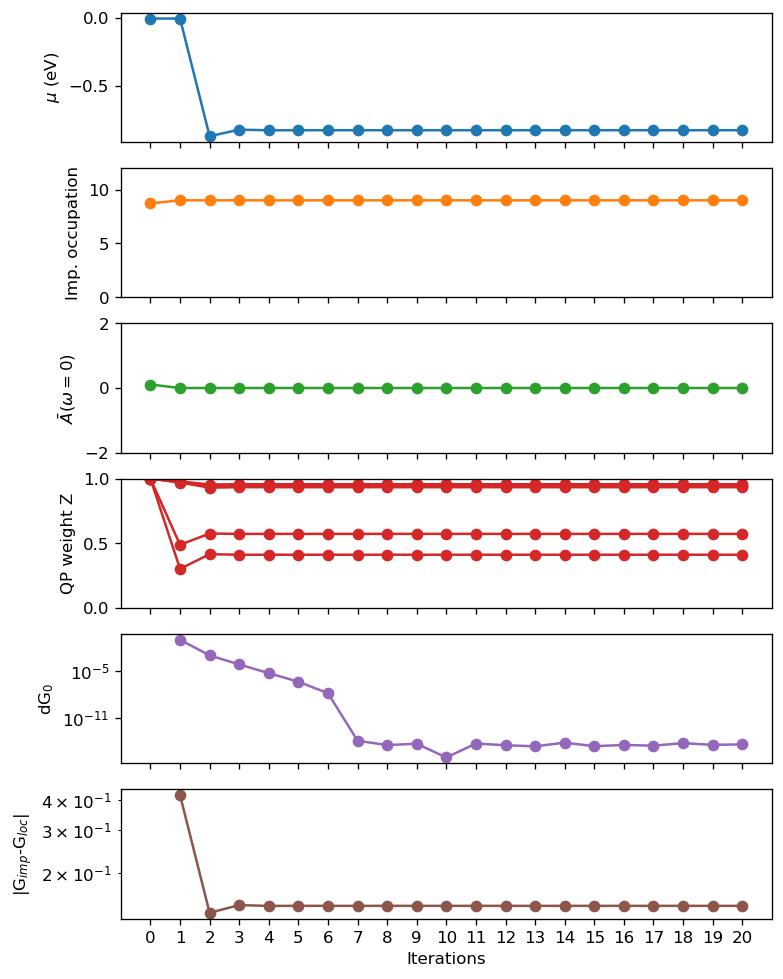

In [4]:
fig, ax = plt.subplots(nrows=6, dpi=120, figsize=(7,10), sharex=True)

# chemical potential
ax[0].plot(obs['iteration'], obs['mu'], '-o', color='C0')
ax[0].set_ylabel(r'$\mu$ (eV)')

# imp occupation
imp_occ = np.array(obs['imp_occ'][0]['up'])+np.array(obs['imp_occ'][0]['down'])
ax[1].plot(obs['iteration'], imp_occ, '-o', color='C1')
ax[1].set_ylim(0,12)
ax[1].set_ylabel('Imp. occupation')

# A(w=0)
Aw0 = -1*(np.array(obs['imp_gb2'][0]['up'])+np.array(obs['imp_gb2'][0]['down']))
ax[2].plot(obs['iteration'], Aw0 , '-o', color='C2')
ax[2].set_ylim(-2,2)
ax[2].set_ylabel(r'$\bar{A}(\omega=0$)')

# Z
Z = 0.5*(np.array(obs['orb_Z'][0]['up'])+np.array(obs['orb_Z'][0]['down']))
ax[3].plot(obs['iteration'], Z, '-o', color='C3')
ax[3].set_ylim(0,1.0)
ax[3].set_ylabel(r'QP weight Z')

# convergence of Weiss field
ax[4].semilogy(obs['iteration'][1:], conv_obs['d_G0'][0], '-o', color='C4')
ax[4].set_ylabel(r'dG$_0$')

# convergence of DMFT self-consistency condition Gimp-Gloc
ax[5].semilogy(obs['iteration'][1:], conv_obs['d_Gimp'][0], '-o', color='C5')
ax[5].set_ylabel(r'|G$_{imp}$-G$_{loc}$|')

ax[-1].set_xticks(range(0,len(obs['iteration'])))
ax[-1].set_xlabel('Iterations')

plt.show()

In [5]:
w90_path = '../../'
w90_dict = {'w90_seed': 'nio', 'w90_path': w90_path, 'mu_tb':15.514 , 'n_orb': 8,
            'orbital_order_w90': [0], 'add_spin': False}
proj_on_orb = None 

In [6]:
orbital_order_to = [0]
#freq_mesh_kslice = {'window': [-0.5, 0.5], 'n_w': int(1e6)}
freq_mesh_bands = {'window': [-10, 10], 'n_w': int(5001)}
freq_mesh =  freq_mesh_bands

dmft_path = './nio.h5'

proj_on_orb = orbital_order_to.index(proj_on_orb) if proj_on_orb else None
sigma_dict = {'dmft_path': dmft_path, 'it': 'last_iter', 'orbital_order_dmft': orbital_order_to, 'spin': 'up',
              'block': 0, 'eta': 0.5, 'w_mesh': freq_mesh, 'linearize': False, 'proj_on_orb' : proj_on_orb}

In [7]:
import h5py
f = h5py.File('nio.h5', 'r')
print(f['DMFT_results']['last_iter']['Sigma_Refreq_0']['up_0']['mesh']['max'][()])

10.0


In [8]:
kslice = False

bands_config = {'tb': True, 'alatt': True, 'qp_bands': False, 'sigma': 'calc'}
kslice_config = {'tb': True, 'alatt': True, 'qp_bands': False, 'sigma': 'calc'}
config = kslice_config if kslice else bands_config

w90_path = '../../'
w90_dict = {'w90_seed': 'nio', 'w90_path': w90_path, 'mu_tb':15.514 , 'n_orb': 8,
            'orbital_order_w90': [0], 'add_spin': False}
proj_on_orb = None 

G [0. 0. 0.]
K [0.375 0.375 0.75 ]
L [0.5 0.5 0.5]
U [0.625 0.25  0.625]
W [0.5  0.25 0.75]
X [0.5 0.  0.5]


<Axes3DSubplot:>

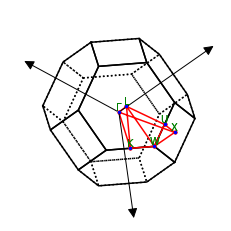

In [9]:
from ase.io.espresso import read_espresso_in
scf_in = '../../nio.scf.in'

# read scf file
atoms = read_espresso_in(scf_in)
# set up cell and path
lat = atoms.cell.get_bravais_lattice()
path = atoms.cell.bandpath('', npoints=100)
kpts_dict = path.todict()['special_points']

for key, value in kpts_dict.items():
    print(key, value)
lat.plot_bz()

In [10]:
tb_bands = {'bands_path': [('L', 'G'), ('G', 'X'), ('X', 'W'),('W','L'),('L','K'),('K','G')], 'n_k': 50}
tb_bands.update(kpts_dict)
tb_config = tb_bands

In [11]:
orbital_order_to = [0]
freq_mesh_kslice = {'window': [-0.5, 0.5], 'n_w': int(1e6)}
freq_mesh_bands = {'window': [-10, 10], 'n_w': int(5001)}
freq_mesh = freq_mesh_kslice if kslice else freq_mesh_bands

dmft_path = './nio.h5'

proj_on_orb = orbital_order_to.index(proj_on_orb) if proj_on_orb else None
sigma_dict = {'dmft_path': dmft_path, 'it': 'last_iter', 'orbital_order_dmft': orbital_order_to, 'spin': 'up',
               'eta': 0.5, 'w_mesh': freq_mesh, 'linearize': False, 'proj_on_orb' : proj_on_orb}

In [12]:
from timeit import default_timer as timer
start_time = timer()

tb_data, alatt_k_w, freq_dict = pcb.get_dmft_bands(fermi_slice=kslice, with_sigma= 'calc', add_mu_tb=True,
                                                   orbital_order_to=orbital_order_to, qp_bands=config['qp_bands'],
                                                   **w90_dict, **tb_config, **sigma_dict)

print('Run took {0:.3f} s'.format(timer() - start_time))

H(R=0):
     14.0261  0.0000  0.0003 -0.0017  0.0000 -0.0233 -0.0322 -0.0178
      0.0000 14.1624  0.0000  0.0000 -0.0875  0.0117  0.0490  0.0316
      0.0003  0.0000 14.1450 -0.0905  0.0000  0.0068  0.0277  0.0187
     -0.0017  0.0000 -0.0905 14.1027  0.0000  0.0195  0.0330  0.0317
      0.0000 -0.0875  0.0000  0.0000 14.1040  0.0312  0.0684  0.0336
     -0.0233  0.0117  0.0068  0.0195  0.0312 11.2558  0.0000  0.0028
     -0.0322  0.0490  0.0277  0.0330  0.0684  0.0000 11.2697  0.0000
     -0.0178  0.0316  0.0187  0.0317  0.0336  0.0028  0.0000 11.2682
Setting Sigma from ./nio.h5
Adding mu_tb to DMFT μ; assuming DMFT was run with subtracted dft μ.
μ=14.6876 eV set for calculating A(k,ω)
Run took 30.684 s


(-10.0, 10.0)

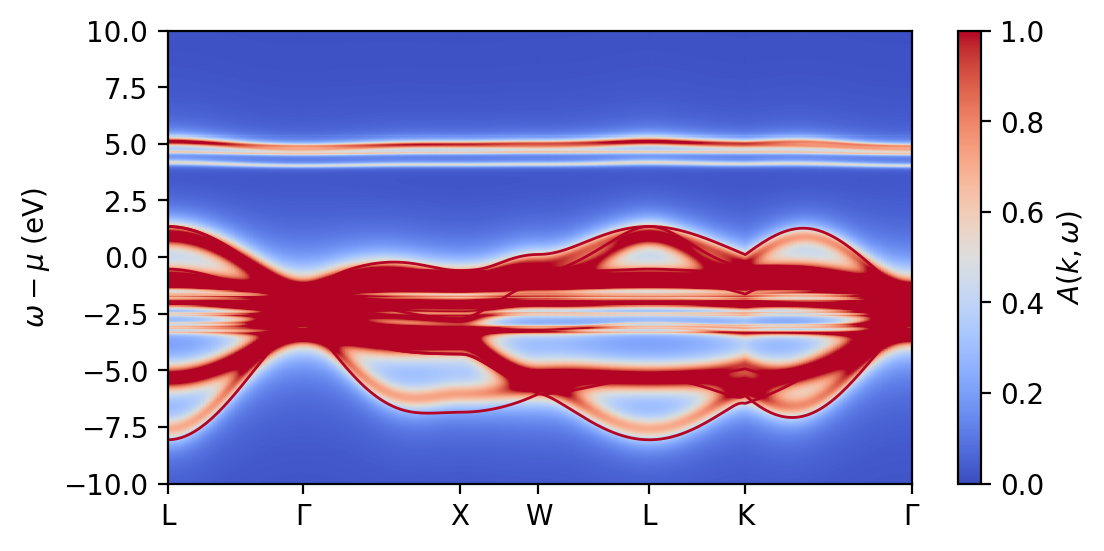

In [13]:
plot_config = {'colorscheme_alatt': 'coolwarm', 'colorscheme_bands': 'coolwarm', 'colorscheme_kslice': 'PuBuGn',
               'colorscheme_qpbands': 'Greens', 'vmax': 1.0}
fig, ax = plt.subplots(1, figsize=(6,3), dpi=200)

pcb.plot_bands(fig, ax, alatt_k_w, tb_data, freq_dict, w90_dict['n_orb'], dft_mu=15.514,
                   tb=config['tb'], alatt=config['alatt'], qp_bands=config['qp_bands'], **plot_config)

ax.set_ylim(-10,10)